# Trend Volatility Replication

In [13]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

# Getting Data

In [2]:
fut_path    = r"C:\Users\Diego\Documents\GitHub\TrendConvexity\data\FuturesData.parquet"
hf_path     = r"C:\Users\Diego\Documents\GitHub\TrendConvexity\data\hf_indices.parquet"
ticker_path = r"A:\BBGFuturesManager_backup_backup\root\fut_tickers.xlsx"
spx_path    = r"C:\Users\Diego\Documents\GitHub\TrendConvexity\data\spx.parquet"

In [3]:
df_px = (pd.read_parquet(
    path = fut_path, engine = "pyarrow").
    pivot(index = "date", columns = "security", values = "PX_LAST"))

In [4]:
df_dt = (df_px.diff().apply(
    lambda x: x / x.ewm(span = 10, adjust = False).std()))

In [5]:
window = 180

df_tf_signal = (df_dt.apply(
    lambda x: x.ewm(span = window, adjust = False).mean()).
    shift().
    apply(lambda x: np.sign(x)))

In [6]:
df_vol_signal1 = (df_px.pct_change().apply(
    lambda x: x.ewm(span = window, adjust = False).std() - x.ewm(span = window / 2, adjust = False).std()).
    shift().
    apply(lambda x: np.sign(x)))

df_vol_signal2 = (df_dt.apply(
    lambda x: x.ewm(span = window, adjust = False).std() - x.ewm(span = window / 2, adjust = False).std()).
    shift().
    apply(lambda x: np.sign(x)))

In [7]:
df_tf_port = ((df_px.pct_change() * df_tf_signal).apply(
    lambda x: x * (0.01 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252)))).
    mean(axis = 1).
    to_frame(name = "tf_rtn"))

In [8]:
df_vol_port1 = ((df_px.pct_change() * df_vol_signal1).apply(
    lambda x: x * (0.01 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252)))).
    drop(columns = ["SER1 Comdty"]).
    mean(axis = 1).
    to_frame(name = "vol_rtn1"))

In [9]:
df_vol_port2 = ((df_px.pct_change() * df_vol_signal2).apply(
    lambda x: x * (0.01 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252)))).
    drop(columns = ["SER1 Comdty"]).
    mean(axis = 1).
    to_frame(name = "vol_rtn2"))

In [10]:
df_combined = (df_tf_port.merge(
    right = df_vol_port1, how = "inner", on = ["date"]).
    merge(right = df_vol_port2, how = "inner", on = ["date"]).
    apply(lambda x: x * (0.1 / (x.ewm(span = 100, adjust = False).std() * np.sqrt(252)))).
    dropna().
    reset_index().
    melt(id_vars = "date").
    assign(value = lambda x: np.where(x.date == x.date.min(), 0, x.value)).
    rename(columns = {"variable": ""}).
    pivot(index = "date", columns = "", values = "value"))

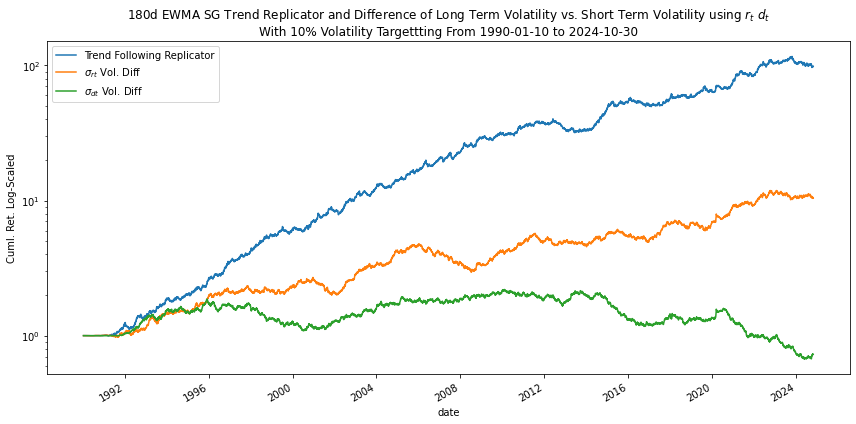

In [11]:
(df_combined.apply(
    lambda x: np.cumprod(1 + x)).
    rename(columns = {
        "tf_rtn"  : "Trend Following Replicator",
        "vol_rtn1": r"$\sigma_{rt}$" + " Vol. Diff",
        "vol_rtn2": r"$\sigma_{dt}$" + " Vol. Diff"}).
    plot(
        logy    = True,
        figsize = (12,6),
        ylabel  = "Cuml. Ret. Log-Scaled",
        title   = (
            "180d EWMA SG Trend Replicator and Difference of Long Term Volatility vs. Short Term Volatility using " 
            + r"$r_t$" + " "+ r"$d_t$" + 
            "\nWith 10% Volatility Targettting From {} to {}".format(
                df_combined.index.min().date(),
                df_combined.index.max().date()))))

plt.tight_layout()

In [31]:
df_corr = (df_combined.rename(columns = {
    "tf_rtn"  : "Trend\nReplicator",
    "vol_rtn1": r"$\sigma_{rt}$" + "\nVol Diff",
    "vol_rtn2": r"$\sigma_{dt}$" + "\nVol Diff"}).
    corr())

Text(0.5, 1.0, 'Correlation Matrix between Return Series')

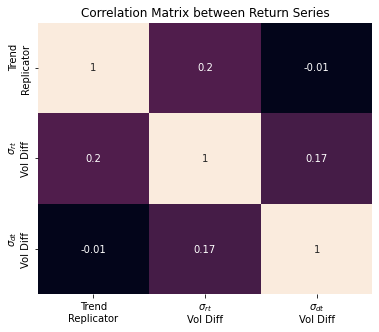

In [33]:
fig, axes = plt.subplots(figsize = (6,5))

(sns.heatmap(
    ax    = axes,
    data  = df_corr, 
    annot = True,
    cbar  = False))

axes.set_title("Correlation Matrix between Return Series")

<AxesSubplot:xlabel='Strategy', ylabel='Annualized Sharpe'>

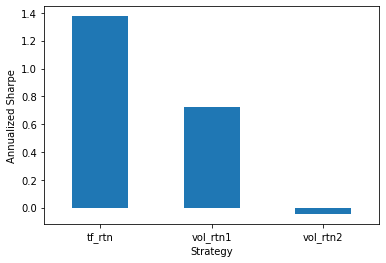

In [41]:
(df_combined.agg(
    lambda x: x.mean() / x.std() * np.sqrt(252)).
    to_frame(name = "sharpe").
    plot(
        kind   = "bar",
        xlabel = "Strategy",
        ylabel = "Annualized Sharpe",
        rot    = 0,
        title  = "",
        legend = False))